## Import modules

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import datetime
import matplotlib.pyplot as plt

sys.path.insert(0, '/mnt/afml/ml_finance/mlfinlab')
import mlfinlab as ml
from mlfinlab.data_structures import imbalance_data_structures as imbar, run_data_structures as rbar, standard_data_structures as bar

sys.path.insert(0, '/mnt/afml/ml_finance/finance_ml')
from finance_ml.multiprocessing import mp_pandas_obj

## Plot

In [2]:
def plot_bars(df, df_bar, desc='bar'):
    plt.figure(figsize = (18, 8))
    plt.title('Bars over the prices')
    plt.plot(df.index, df['PRICE'], label = 'Raw prices', color = 'blue')
    plt.plot(df_bar.index, df_bar['close'], ls = '', markersize = 5, marker = 'o', color = 'red', label = desc)
    plt.legend()
    plt.show()

## Load data

In [3]:
def load_parq(fname):
    table = pq.read_table(fname)
    df = table.to_pandas()
    df = df.set_index('TIMESTAMP')
    ''' 중복된 index 제거, volume은 더해준다 '''
    df = df.sort_values(by='TIMESTAMP')  # 중복 데이터 무시
    df_v = df.groupby(df.index).sum()
    df = df.loc[~df.index.duplicated(keep='first')]
    df['V'] = df_v['V']
    df['DV'] = df_v['DV']
    return df

In [4]:
fname = 'dataset/TRADE_A233740_2018.parq'
df = load_parq(fname)

In [5]:
fname = 'dataset/TRADE_A233740_2018.csv'
if not os.path.exists(fname):
    df_csv = df.reset_index()[['TIMESTAMP', 'PRICE', 'V']]
    df_csv.columns = ['date_time', 'price', 'volume']
    df_csv['price'] = df_csv['price'].astype('float')
    df_csv.to_csv(fname, index=False)
vbar = bar.get_volume_bars(fname, threshold=1e4)
vbar.index = pd.to_datetime(vbar.index)
fname = 'dataset/VBAR_A233740_2018.csv'
vbar.to_csv(fname)

Reading data in batches:
Batch number: 0
Returning bars 



In [6]:
vbar.tail()

,open,high,low,close,volume
date_time,,,,,
2018-12-28 15:19:39.289,11965.0,11965.0,11960.0,11965.0,13029
2018-12-28 15:19:44.281,11965.0,11965.0,11960.0,11965.0,10119
2018-12-28 15:19:45.135,11965.0,11965.0,11965.0,11965.0,10425
2018-12-28 15:19:47.719,11965.0,11965.0,11965.0,11965.0,11756
2018-12-28 15:19:52.956,11965.0,11965.0,11965.0,11965.0,10474


In [7]:
df.tail()

,PRICE,BID,ASK,V,DV
TIMESTAMP,,,,,
2018-12-28 15:19:55.206,11965,11960,11965,856,10242040
2018-12-28 15:19:55.717,11965,11960,11965,16,191440
2018-12-28 15:19:56.329,11965,11960,11965,2540,30391100
2018-12-28 15:19:56.950,11965,11965,11970,500,5982500
2018-12-28 15:19:57.675,11965,11965,11970,10,119650


In [8]:
print(df.shape)
print(vbar.shape)

(7647271, 5)
(331841, 5)


/mnt/afml/venv/lib/python3.5/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


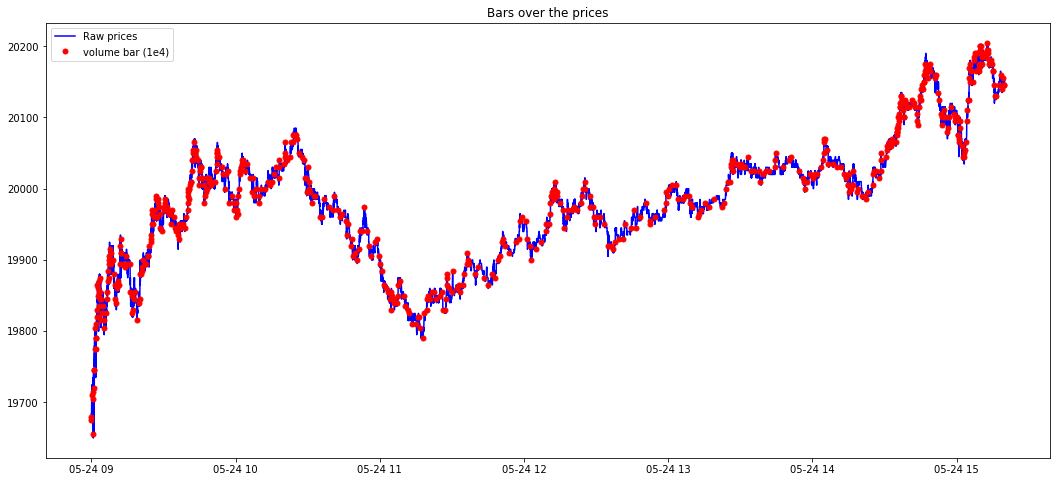

In [9]:
df_sub = df[df.index>datetime.datetime(2018,5,24,9,0)]
df_sub = df_sub[df_sub.index<datetime.datetime(2018,5,25,9,0)]
vbar_sub = vbar[vbar.index>datetime.datetime(2018,5,24,9,0)]
vbar_sub = vbar_sub[vbar_sub.index<datetime.datetime(2018,5,25,9,0)]
plot_bars(df_sub, vbar_sub, 'volume bar (1e4)')

## Triple barrier

In [10]:
# Compute daily volatility
daily_vol = ml.util.get_daily_vol(close=vbar['close'], lookback=50)

# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = ml.filters.cusum_filter(vbar['close'], threshold=daily_vol.mean()*0.3)

# Compute vertical barrier
vertical_barriers = ml.labeling.add_vertical_barrier(t_events=cusum_events, close=vbar['close'], num_days=1)

In [12]:
print(vbar.shape)
print(cusum_events.shape)
print(vertical_barriers.shape)

(331841, 5)
(86530,)
(86210,)


## Build Label

In [13]:
pt_sl = [1, 2]
min_ret = 0.005
triple_barrier_events = ml.labeling.get_events(close=vbar['close'],
                                               t_events=cusum_events,
                                               pt_sl=pt_sl,
                                               target=daily_vol,
                                               min_ret=min_ret,
                                               num_threads=3,
                                               vertical_barrier_times=vertical_barriers)

/mnt/afml/ml_finance/mlfinlab/mlfinlab/labeling/labeling.py:117: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]
2019-05-26 13:37:28.681553 100.0% apply_pt_sl_on_t1 done after 0.55 minutes. Remaining 0.0 minutes.


In [14]:
print(triple_barrier_events.shape)

(19118, 2)


In [15]:
vertical_barriers.loc[vertical_barriers.index>datetime.datetime(2018,5,24,9,0)].head()

2018-05-24 09:00:01.031   2018-05-25 09:00:14.483
2018-05-24 09:00:06.354   2018-05-25 09:00:14.483
2018-05-24 09:00:44.746   2018-05-25 09:00:56.925
2018-05-24 09:00:52.812   2018-05-25 09:00:56.925
2018-05-24 09:01:05.020   2018-05-25 09:01:14.931
Name: date_time, dtype: datetime64[ns]

In [16]:
triple_barrier_events.loc[triple_barrier_events.index>datetime.datetime(2018,5,23,9,0)].head()

,t1,trgt
2018-05-24 09:27:03.716,2018-05-24 09:42:52.085,0.005060
2018-05-24 09:27:44.483,2018-05-24 11:01:44.613,0.005773
2018-05-24 09:28:20.956,2018-05-24 09:42:52.085,0.005890
2018-05-24 09:29:22.306,2018-05-24 09:42:52.085,0.005898
2018-05-24 09:30:03.968,2018-05-24 11:03:14.446,0.005887


## Concurrency and Uniqueness

In [17]:
def get_num_co_events(close_idx, t1, molecule):
    # Find events that span the period defined by molecule
    t1 = t1.fillna(close_idx[-1])
    t1 = t1[t1 >= molecule[0]]
    t1 = t1.loc[:t1[molecule].max()]
    # Count the events
    iloc = close_idx.searchsorted(np.array([t1.index[0], t1.max()]))
    count = pd.Series(0, index=close_idx[iloc[0]: iloc[1] + 1])
    for t_in, t_out in t1.iteritems():
        count.loc[t_in: t_out] += 1
    return count.loc[molecule[0]: t1[molecule].max()]

In [18]:
num_threads = 24
num_co_events = mp_pandas_obj(get_num_co_events,
                              ('molecule', triple_barrier_events.index),
                              num_threads,
                              close_idx=vbar.index,
                              t1=triple_barrier_events['t1'])

# num_co_events = num_co_events.loc[~num_co_events.index.duplicated(keep='last')]
# num_co_events = num_co_events.reindex(close.index).fillna(0)

2019-05-26 13:37:40.408591 100.0% get_num_co_events done after 0.19 minutes. Remaining 0.0 minutes.


## Plot concurrency

In [19]:
num_co_events_sub = num_co_events[num_co_events.index>datetime.datetime(2018,5,24,9,0)]
num_co_events_sub = num_co_events_sub[num_co_events_sub.index<datetime.datetime(2018,5,25,9,0)]
daily_vol_sub = daily_vol[daily_vol.index>datetime.datetime(2018,5,24,9,0)]
daily_vol_sub = daily_vol_sub[daily_vol_sub.index<datetime.datetime(2018,5,25,9,0)]

In [20]:
num_co_events_sub.head()

2018-05-24 09:00:01.031    0
2018-05-24 09:00:01.434    0
2018-05-24 09:00:06.354    0
2018-05-24 09:00:28.892    0
2018-05-24 09:00:34.106    0
dtype: int64

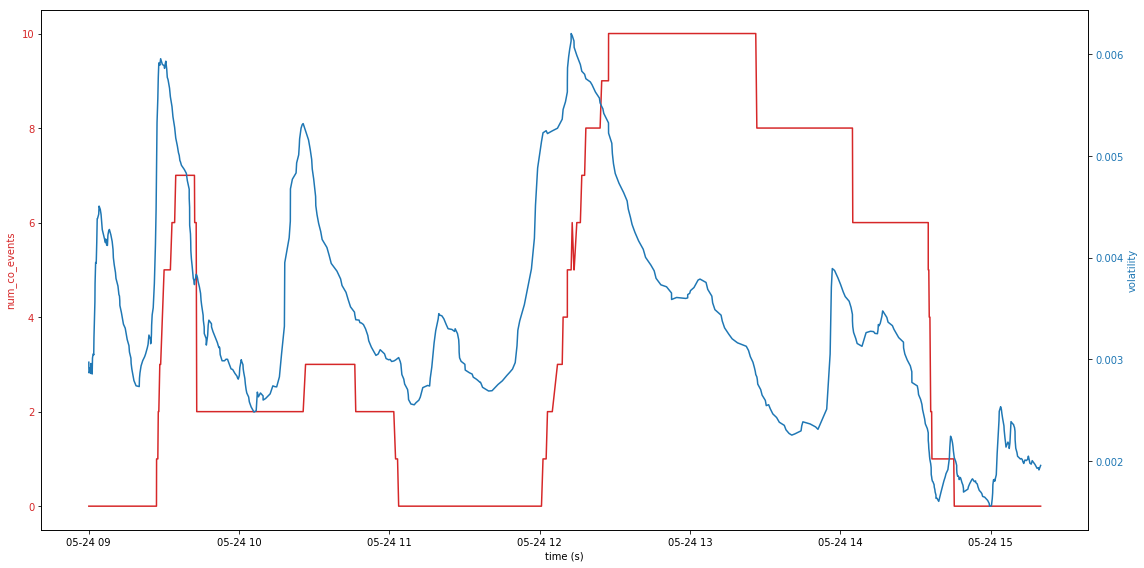

In [21]:
fig, ax1 = plt.subplots(figsize=(16, 8))

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('num_co_events', color=color)
ax1.plot(num_co_events_sub, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('volatility', color=color)  # we already handled the x-label with ax1
ax2.plot(daily_vol_sub, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Get avg uniqueness

In [26]:
def get_ind_matrix(bar_idx, t1):
    ind_m = pd.DataFrame(0, index=bar_idx,
                         columns=range(t1.shape[0]))
    for  i, (t0_, t1_) in enumerate(t1.iteritems()):
        ind_m.loc[t0_:t1_, i] = 1
    return ind_m

def get_avg_uniq(ind_m, c=None):
    if c is None:
        c = ind_m.sum(axis=1)
    ind_m = ind_m.loc[c > 0]
    c = c.loc[c > 0]
    u = ind_m.div(c, axis=0)
    avg_u = u[u>0].mean()
    avg_u = avg_u.fillna(0)
    return avg_u

In [31]:
triple_barrier_events_sub = triple_barrier_events.loc[triple_barrier_events.index>datetime.datetime(2018,5,24,9,0)].head()
triple_barrier_events_sub = triple_barrier_events_sub.loc[triple_barrier_events_sub.index<datetime.datetime(2018,5,25,9,0)].head()

In [32]:
ind_m = get_ind_matrix(vbar_sub['close'].index, triple_barrier_events_sub['t1'])
avg_uniq = get_avg_uniq(ind_m)
avg_uniq.head()

0    0.267687
1    0.425958
2    0.207197
3    0.201190
4    0.433918
dtype: float64

In [33]:
avg_uniq.shape

(5,)

In [34]:
def get_time_decay(tw, last_w=1., truncate=0, is_exp=False):
    cum_w = tw.sort_index().cumsum()
    init_w = 1.
    if is_exp:
        init_w = np.log(init_w)
    if last_w >= 0:
        if is_exp:
            last_w = np.log(last_w)
        slope = (init_w - last_w) / cum_w.iloc[-1]
    else:
        slope = init_w / ((last_w + 1) * cum_w.iloc[-1])
    const = init_w - slope * cum_w.iloc[-1]
    weights = const + slope * cum_w
    if is_exp:
        weights =np.exp(weights)
    weights[weights < truncate] = 0
    return weights

def get_sample_tw(t1, num_co_events, molecule):
    wght = pd.Series(index=molecule)
    for t_in, t_out in t1.loc[wght.index].iteritems():
        wght.loc[t_in] = (1. / num_co_events.loc[t_in: t_out]).mean()
    return wght

In [36]:
num_co_events = num_co_events.loc[~num_co_events.index.duplicated(keep='last')]
num_co_events = num_co_events.reindex(vbar.index).fillna(0)
tw = mp_pandas_obj(get_sample_tw,
                   ('molecule', triple_barrier_events.index),
                   num_threads,
                   t1=triple_barrier_events['t1'],
                   num_co_events=num_co_events)

2019-05-26 13:54:55.338721 100.0% get_sample_tw done after 0.14 minutes. Remaining 0.0 minutes.


In [38]:
tw.head()

2018-01-03 10:08:12.341    0.268794
2018-01-03 10:09:30.291    0.260932
2018-01-03 10:10:56.199    0.235824
2018-01-03 10:13:53.973    0.202857
2018-01-03 10:15:46.552    0.229375
dtype: float64

In [39]:
tw_sub = tw.loc[tw.index>datetime.datetime(2018,5,24,9,0)].head()
tw_sub = tw_sub.loc[tw_sub.index<datetime.datetime(2018,5,25,9,0)].head()

In [43]:
tw_sub

2018-05-24 09:27:03.716    0.233771
2018-05-24 09:27:44.483    0.393418
2018-05-24 09:28:20.956    0.169426
2018-05-24 09:29:22.306    0.161621
2018-05-24 09:30:03.968    0.400808
dtype: float64

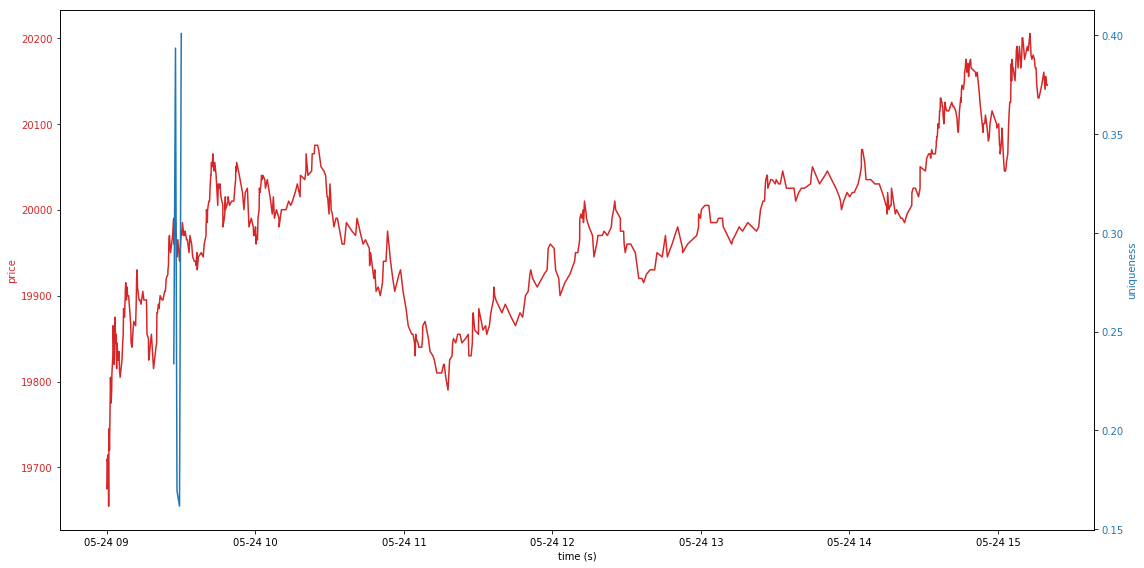

In [42]:
fig, ax1 = plt.subplots(figsize=(16, 8))

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('price', color=color)
ax1.plot(vbar_sub['close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('uniqueness', color=color)  # we already handled the x-label with ax1
ax2.plot(tw_sub, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()